In [1]:
import pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.read_csv("ENE_TD_28062024161736145.csv")

#Obtener valores importantes para graficar o sacar conclusiones
dataframe_clean = dataframe[["DTI_CL_TRIMESTRE_MOVIL","DTI_CL_REGION","Región","Sexo","Value"]]

months_dict = {
        'V01': ('Enero', 1), 'V02': ('Febrero', 2), 'V03': ('Marzo', 3), 'V04': ('Abril', 4),
        'V05': ('Mayo', 5), 'V06': ('Junio', 6), 'V07': ('Julio', 7), 'V08': ('Agosto', 8),
        'V09': ('Septiembre', 9), 'V10': ('Octubre', 10), 'V11': ('Noviembre', 11), 'V12': ('Diciembre', 12)
}

dataframe_clean


,DTI_CL_TRIMESTRE_MOVIL,DTI_CL_REGION,Región,Sexo,Value
0,2010-V02,_T,Total país,Ambos sexos,9.039739
1,2010-V02,_T,Total país,Hombres,7.875985
2,2010-V02,_T,Total país,Mujeres,10.849414
3,2010-V02,CHL15,Región de Arica y Parinacota,Ambos sexos,7.747953
4,2010-V02,CHL15,Región de Arica y Parinacota,Hombres,6.509728
...,...,...,...,...,...
14734,2024-V04,CHL11,Región de Aysén del Gral. Carlos Ibáñez del Campo,Hombres,5.697046
14735,2024-V04,CHL11,Región de Aysén del Gral. Carlos Ibáñez del Campo,Mujeres,4.630275
14736,2024-V04,CHL12,Región de Magallanes y La Antártica Chilena,Ambos sexos,7.068031
14737,2024-V04,CHL12,Región de Magallanes y La Antártica Chilena,Hombres,5.893391


In [2]:
def prepare_data(df, year):
    
    """
    Filtra y prepara los datos para un año específico.
    
    Args:
    - df (DataFrame): DataFrame original con los datos.
    - year (str): Año a filtrar en formato 'YYYY'.
    
    Returns:
    - DataFrame: DataFrame filtrado y preparado por mes y sexo.
    """
    
    # Filtrar por año y extraer mes
    df_filtered = df[df['DTI_CL_TRIMESTRE_MOVIL'].str.startswith(year)]
    df_filtered['Mes'] = df_filtered['DTI_CL_TRIMESTRE_MOVIL'].str[-2:].astype(int)
    
    # Mapear número de mes a nombre de mes
    months_dict = {
        1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
        5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
        9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
    }
    df_filtered = df_filtered[df_filtered['Mes'].isin(months_dict.keys())]  # Filtrar solo los meses presentes
    df_filtered['Mes'] = df_filtered['Mes'].map(months_dict)  # Mapear el nombre del mes
    
    # Pivotar para tener sexo como columnas y mes como índice
    df_pivot = df_filtered.pivot_table(index=['Región', 'Mes'], columns='Sexo', values='Value').reset_index()
    
    # Ordenar por región y luego por mes cronológicamente
    df_pivot['Mes'] = pd.Categorical(df_pivot['Mes'], categories=months_dict.values(), ordered=True)
    df_pivot = df_pivot.sort_values(by=['Región', 'Mes'])
    
    return df_pivot

def plot_by_region(df, year):
    """
    Grafica las tasas de desocupación por región para un año específico.
    
    Args:
    - df (DataFrame): DataFrame preparado con los datos por mes y sexo.
    - year (str): Año a mostrar en los gráficos.
    """
    # Obtener las regiones y los meses únicos del DataFrame
    regiones = df['Región'].unique()
    meses = df['Mes'].unique()
    colores = {'Hombres': 'blue', 'Mujeres': 'orange'}
    
    # Iterar sobre cada región para graficar
    for region in regiones:
        # Filtrar el DataFrame para la región actual
        df_region = df[df['Región'] == region]
        
        # Crear una nueva figura y un eje para el gráfico
        fig, ax = plt.subplots(figsize=(10, 6))
        bar_width = 0.35
        index = range(len(meses))
        
        # Iterar sobre los sexos ('Hombres' y 'Mujeres')
        for indice_sexo, sexo in enumerate(['Hombres', 'Mujeres']):
            # Obtener los valores de desocupación para el sexo actual
            valores_sexo = df_region[sexo].tolist()
            
            # Calcular las posiciones de las barras en el eje x
            posiciones_barras = []
            for posicion_base in index:
                posicion_barra = posicion_base + indice_sexo * bar_width
                posiciones_barras.append(posicion_barra)
            
            # Graficar las barras
            barras = ax.bar(
                posiciones_barras,  # Posiciones en el eje x
                valores_sexo,       # Alturas de las barras
                bar_width,          # Ancho de las barras
                label=sexo,         # Etiqueta de la leyenda
                color=colores[sexo] # Color de las barras
            )
        
        # Configurar etiquetas y título del gráfico
        ax.set_xlabel('Mes')
        ax.set_ylabel('Tasa de Desocupación')
        ax.set_title(f'Tasa de Desocupación en {region} ({year})')
        
        # Configurar las etiquetas del eje x
        xtick_positions = []
        for posicion_base in index:
            xtick_position = posicion_base + bar_width / 2
            xtick_positions.append(xtick_position)
        
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(meses, rotation=45, ha='right')
        ax.legend()
        
        # Ajustar el diseño y mostrar el gráfico
        plt.tight_layout()
        plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_13680\1159384777.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Mes'] = df_filtered['DTI_CL_TRIMESTRE_MOVIL'].str[-2:].astype(int)


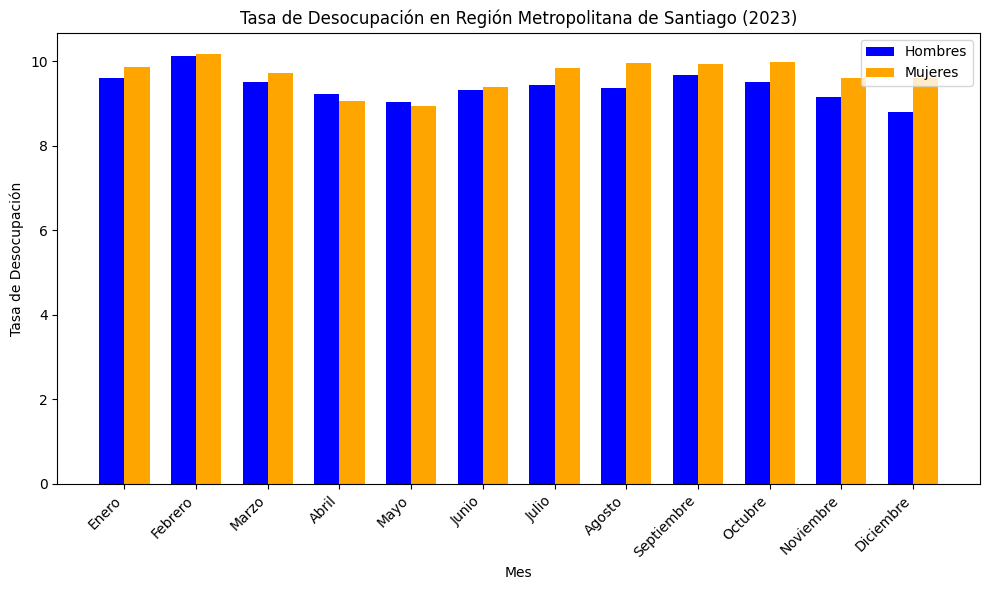

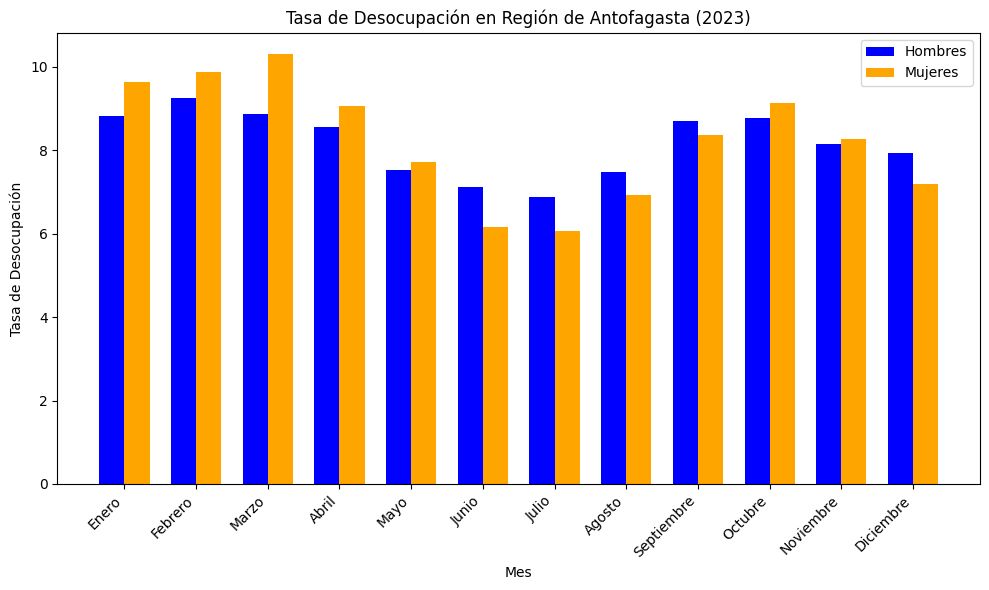

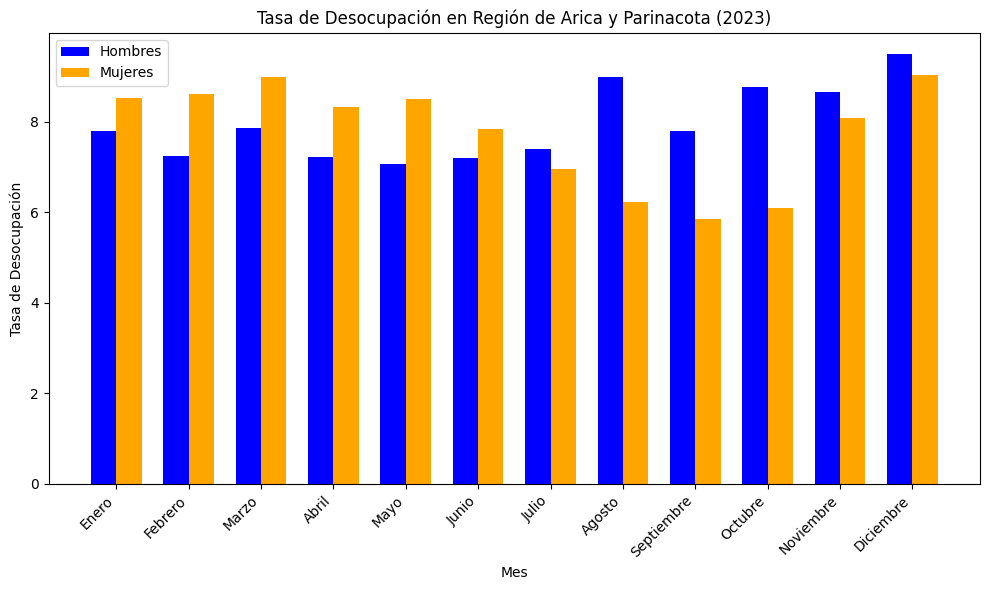

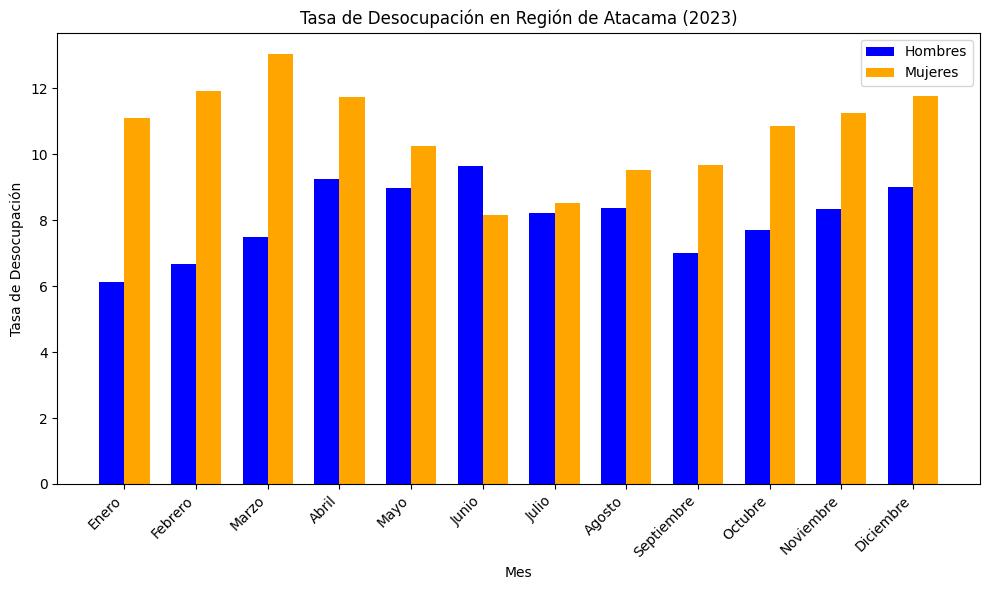

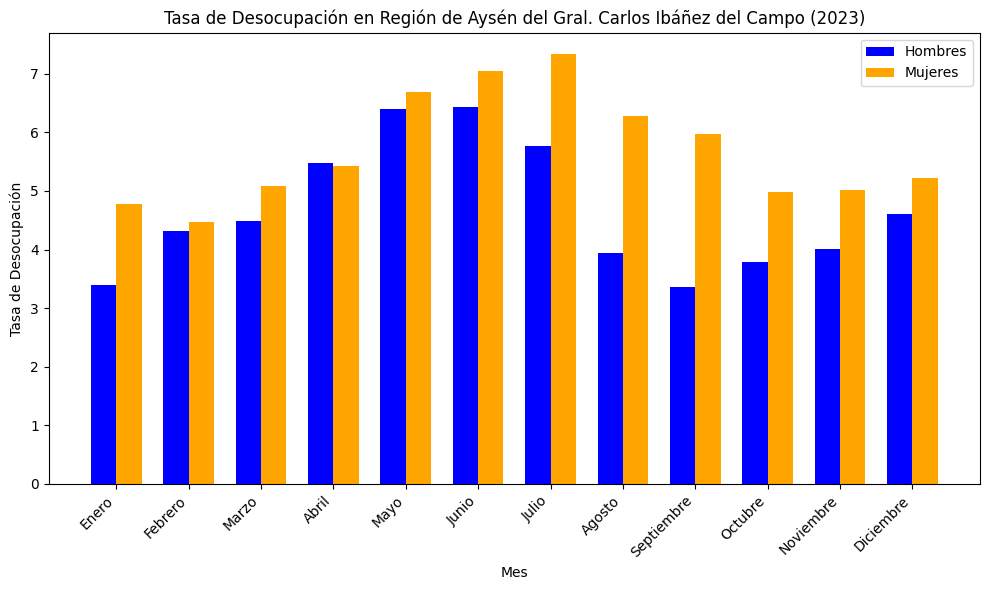

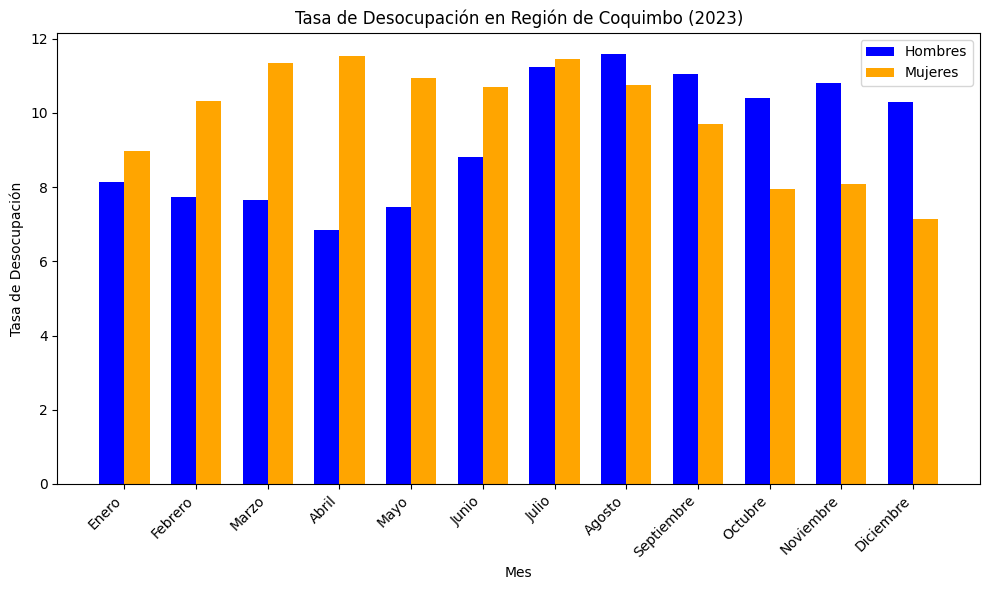

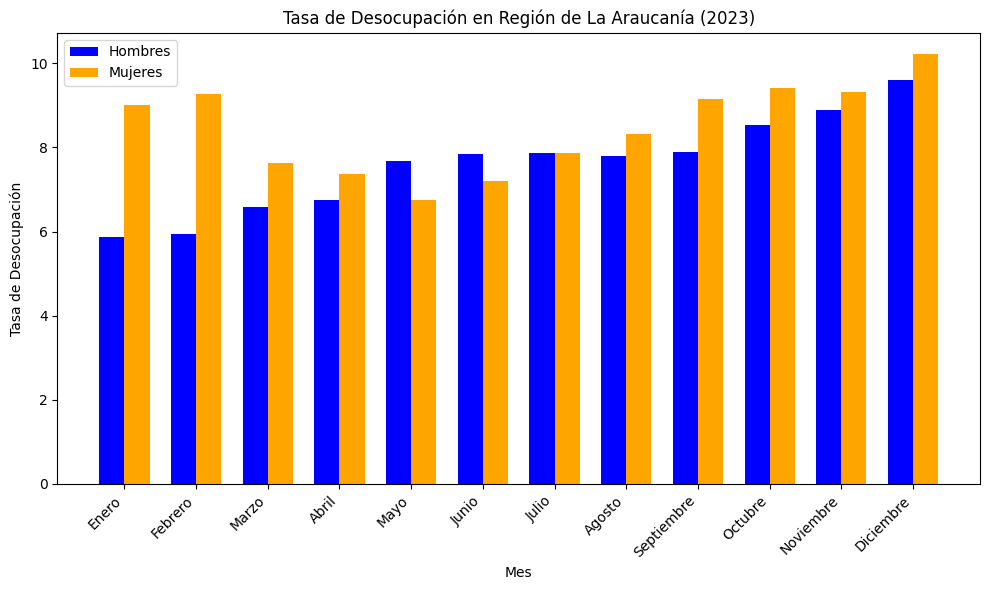

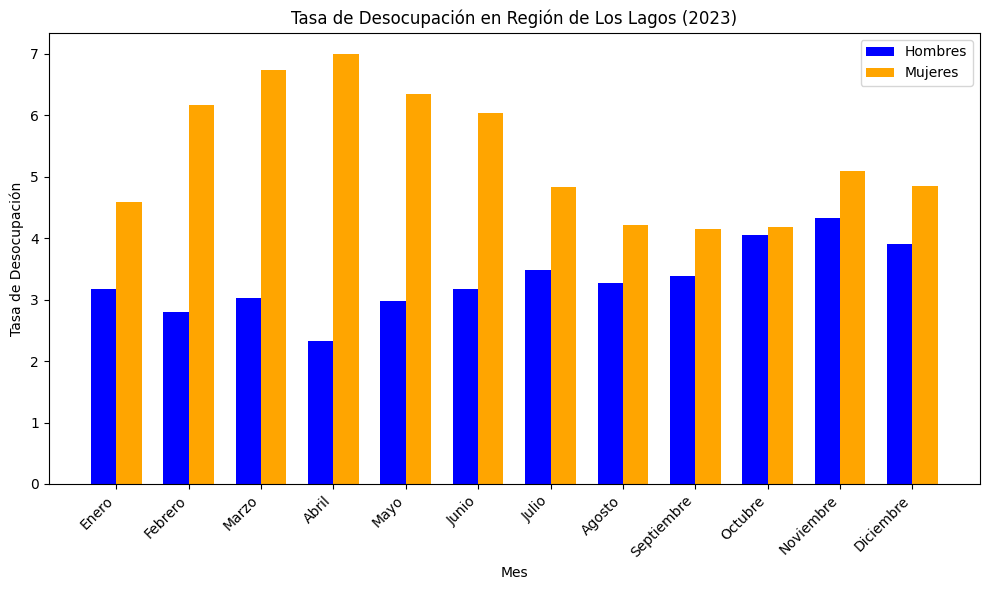

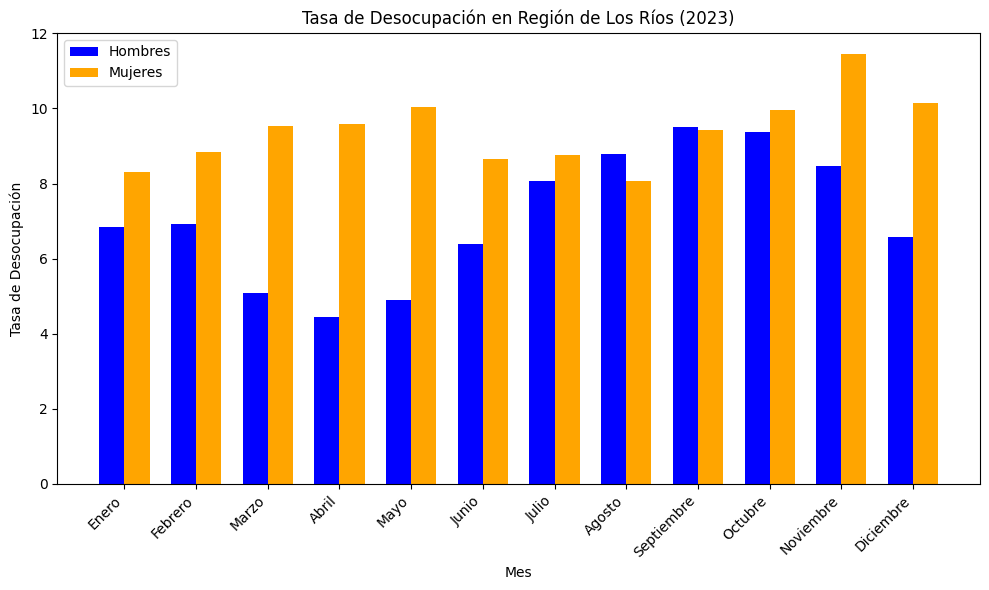

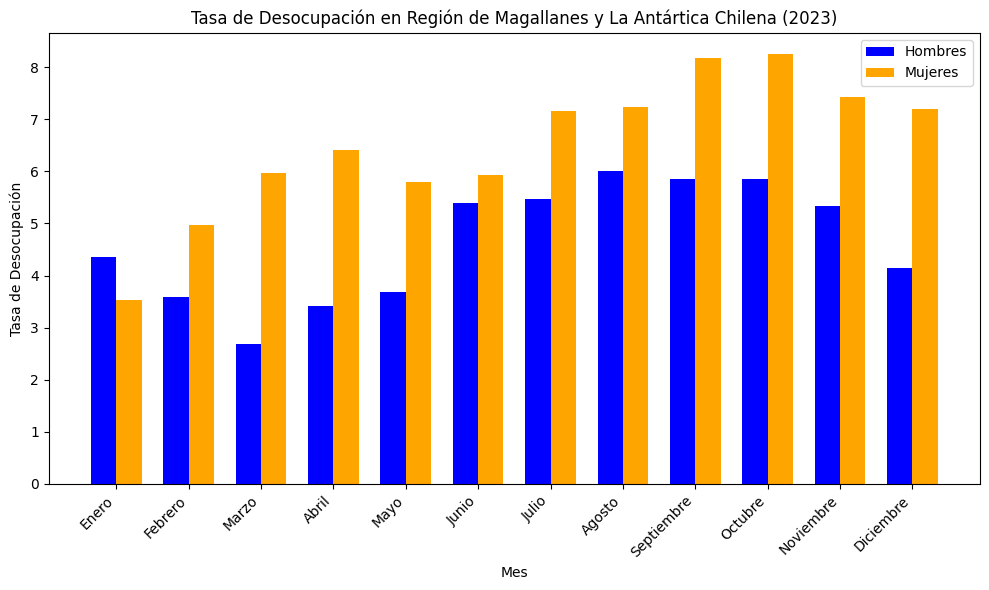

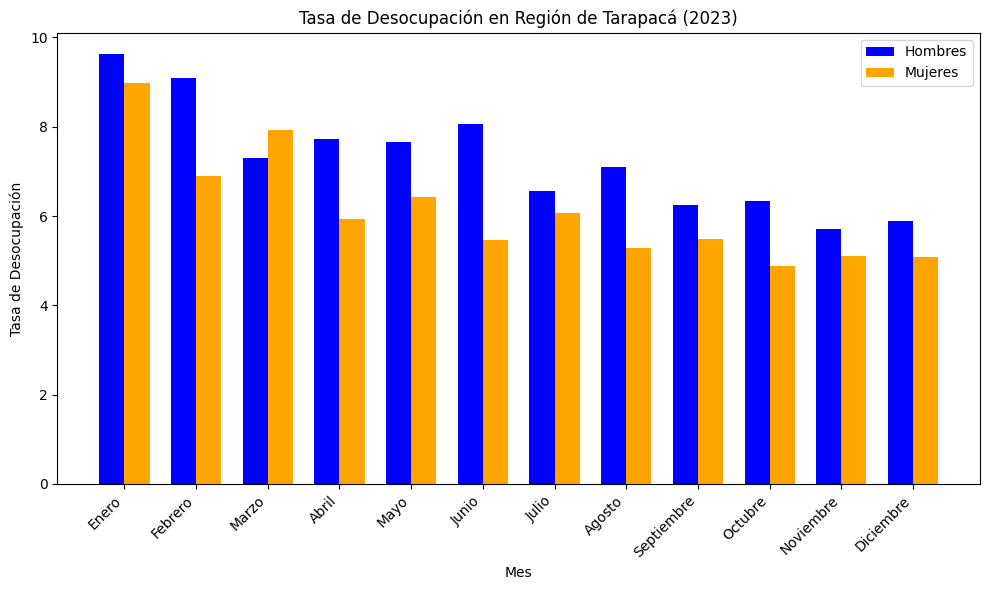

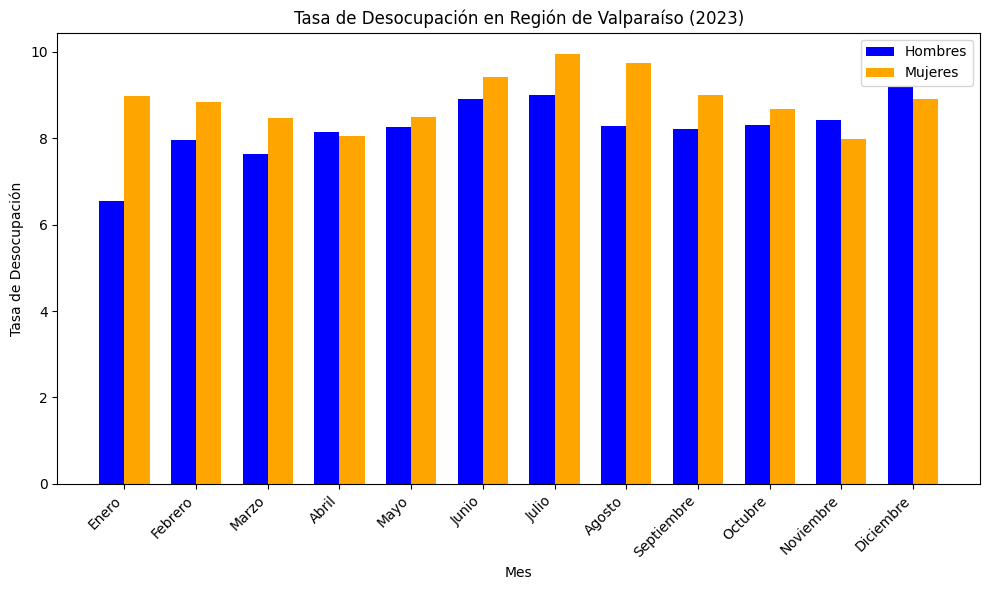

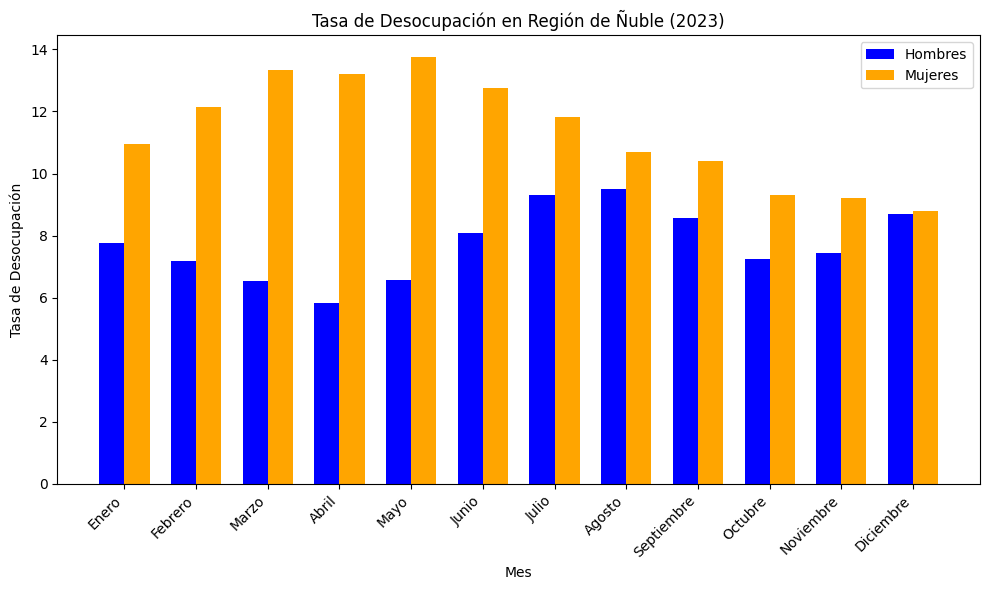

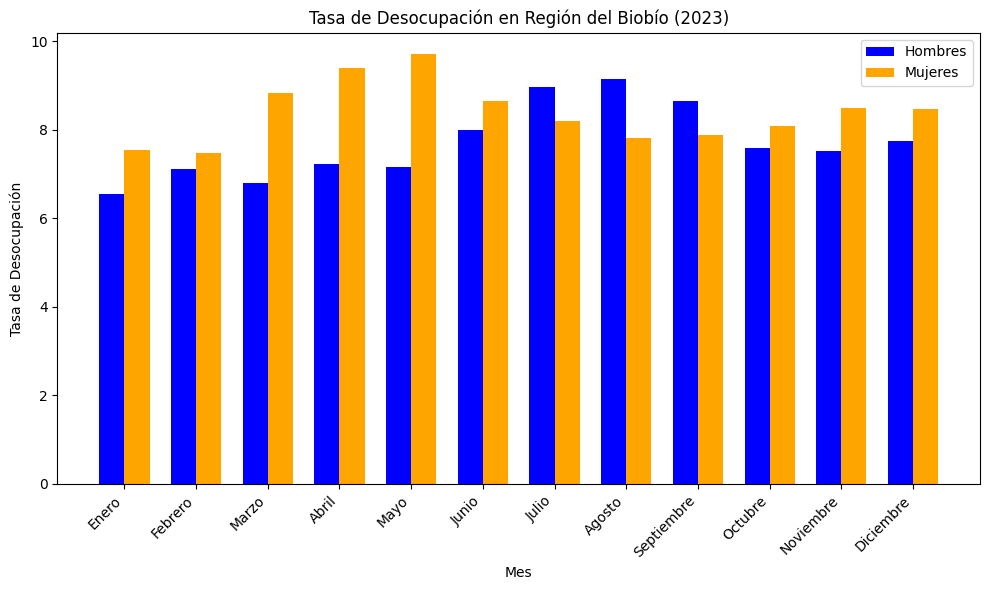

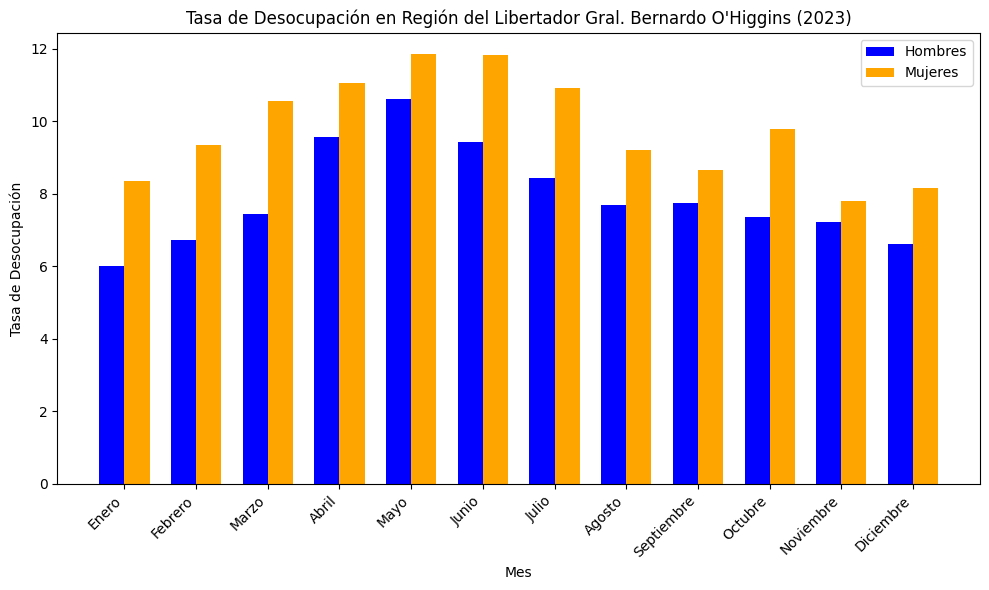

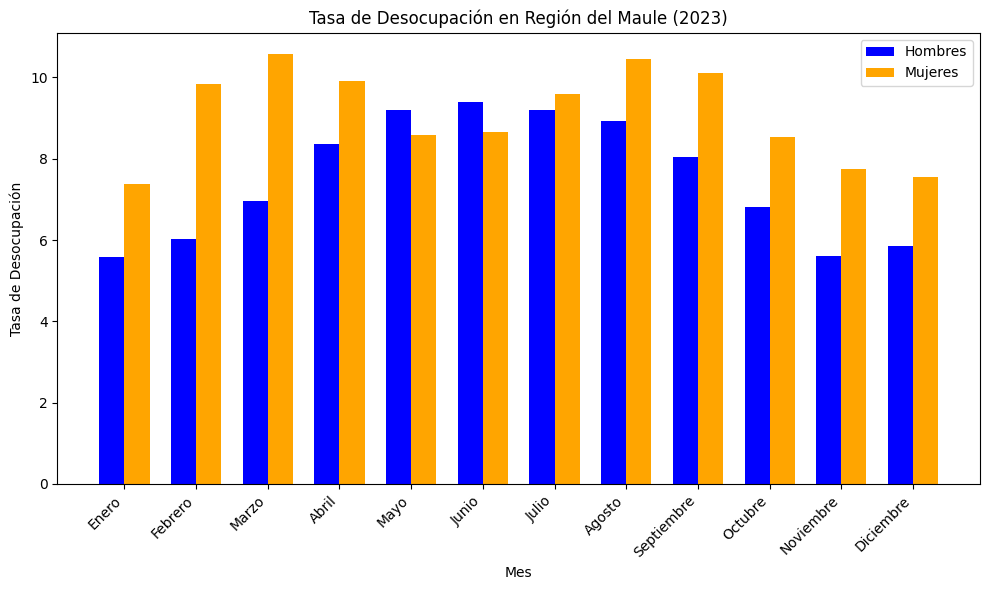

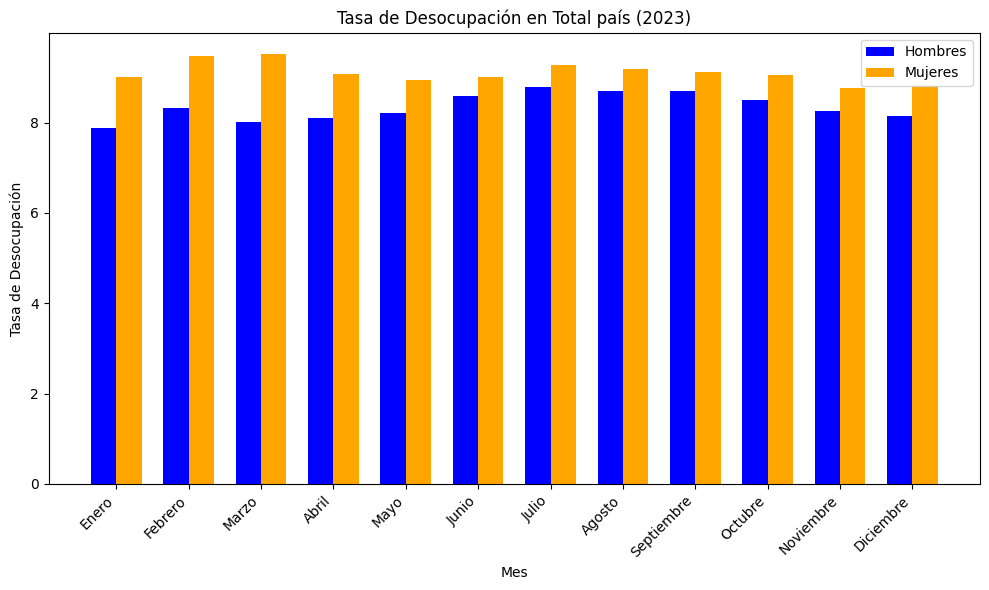

In [3]:
year = "2023"

df_prepared = prepare_data(dataframe_clean, year)

# Graficar por región
plot_by_region(df_prepared, year)
